##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Noise

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/quantum/tutorials/noise"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/quantum/blob/master/docs/tutorials/noise.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/quantum/blob/master/docs/tutorials/noise.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/quantum/docs/tutorials/noise.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

Noise is present in modern day quantum computers. Qubits are susceptible to interference from the surrounding environment, imperfect fabrication, TLS and sometimes even [gamma rays](https://arxiv.org/abs/2104.05219). Until large scale error correction is reached, the algorithms of today must be able to remain functional in the presence of noise. This makes testing algorithms under noise an important step for validating quantum algorithms / models will function on the quantum computers of today.

In this tutorial you will explore the basics of noisy circuit simulation in TFQ via the high level `tfq.layers` API.

## Setup

In [3]:
!pip install -q git+https://github.com/tensorflow/docs

In [4]:
# Update package resources to account for version changes.
import importlib, pkg_resources
importlib.reload(pkg_resources)

<module 'pkg_resources' from '/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/pkg_resources/__init__.py'>

In [5]:
import random
import cirq
import sympy
import tensorflow_quantum as tfq
import tensorflow as tf
import numpy as np
# Plotting
import matplotlib.pyplot as plt
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

2023-03-21 11:41:04.781303: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


## 1. Understanding quantum noise

### 1.1 Basic circuit noise

Noise on a quantum computer impacts the bitstring samples you are able to measure from it. One intuitive way you can start to think about this is that a noisy quantum computer will "insert", "delete" or "replace" gates in random places like the diagram below:

<img src="./images/noise_1.png" width=700>

Building off of this intuition, when dealing with noise, you are no longer using a single pure state $|\psi \rangle$ but instead dealing with an *ensemble* of all possible noisy realizations of your desired circuit: $\rho = \sum_j p_j |\psi_j \rangle \langle \psi_j |$ . Where $p_j$ gives the probability that the system is in $|\psi_j \rangle$ .

Revisiting the above picture, if we knew beforehand that 90% of the time our system executed perfectly, or errored 10% of the time with just this one mode of failure, then our ensemble would be: 

$\rho = 0.9 |\psi_\text{desired} \rangle \langle \psi_\text{desired}| + 0.1 |\psi_\text{noisy} \rangle \langle \psi_\text{noisy}| $

If there was more than just one way that our circuit could error, then the ensemble $\rho$ would contain more than just two terms (one for each new noisy realization that could happen). $\rho$ is referred to as the [density matrix](https://en.wikipedia.org/wiki/Density_matrix) describing your noisy system.

### 1.2 Using channels to model circuit noise

Unfortunately in practice it's nearly impossible to know all the ways your circuit might error and their exact probabilities. A simplifying assumption you can make is that after each operation in your circuit there is some kind of [channel](https://quantumai.google/cirq/noise) that roughly captures how that operation might error. You can quickly create a circuit with some noise:

In [6]:
def x_circuit(qubits):
  """Produces an X wall circuit on `qubits`."""
  return cirq.Circuit(cirq.X.on_each(*qubits))

def make_noisy(circuit, p):
  """Add a depolarization channel to all qubits in `circuit` before measurement."""
  return circuit + cirq.Circuit(cirq.depolarize(p).on_each(*circuit.all_qubits()))

my_qubits = cirq.GridQubit.rect(1, 2)
my_circuit = x_circuit(my_qubits)
my_noisy_circuit = make_noisy(my_circuit, 0.5)
my_circuit

(0, 0): ───X───

(0, 1): ───X───

In [7]:
my_noisy_circuit

(0, 0): ───X───D(0.5)───

(0, 1): ───X───D(0.5)───

You can examine the noiseless density matrix $\rho$ with:

In [8]:
rho = cirq.final_density_matrix(my_circuit)
np.round(rho, 3)

array([[0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j]], dtype=complex64)

And the noisy density matrix $\rho$ with:


In [9]:
rho = cirq.final_density_matrix(my_noisy_circuit)
np.round(rho, 3)

array([[0.111+0.j, 0.   +0.j, 0.   +0.j, 0.   +0.j],
       [0.   +0.j, 0.222+0.j, 0.   +0.j, 0.   +0.j],
       [0.   +0.j, 0.   +0.j, 0.222+0.j, 0.   +0.j],
       [0.   +0.j, 0.   +0.j, 0.   +0.j, 0.444+0.j]], dtype=complex64)

Comparing the two different $ \rho $ 's you can see that the noise has impacted the amplitudes of the state (and consequently sampling probabilities). In the noiseless case you would always expect to sample the $ |11\rangle $ state. But in the noisy state there is now a nonzero probability of sampling $ |00\rangle $ or $ |01\rangle $ or $ |10\rangle $ as well:

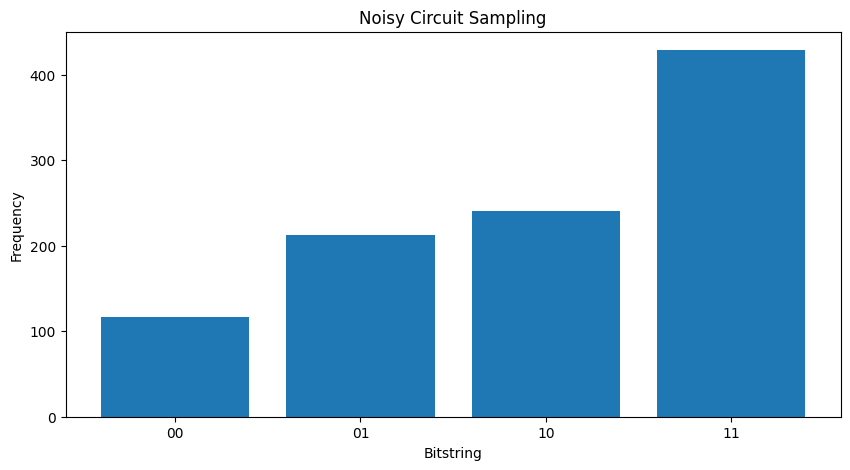

In [10]:
"""Sample from my_noisy_circuit."""
def plot_samples(circuit):
  samples = cirq.sample(circuit + cirq.measure(*circuit.all_qubits(), key='bits'), repetitions=1000)
  freqs, _ = np.histogram(samples.data['bits'], bins=[i+0.01 for i in range(-1,2** len(my_qubits))])
  plt.figure(figsize=(10,5))
  plt.title('Noisy Circuit Sampling')
  plt.xlabel('Bitstring')
  plt.ylabel('Frequency')
  plt.bar([i for i in range(2** len(my_qubits))], freqs, tick_label=['00','01','10','11'])

plot_samples(my_noisy_circuit)

Without any noise you will always get $|11\rangle$:

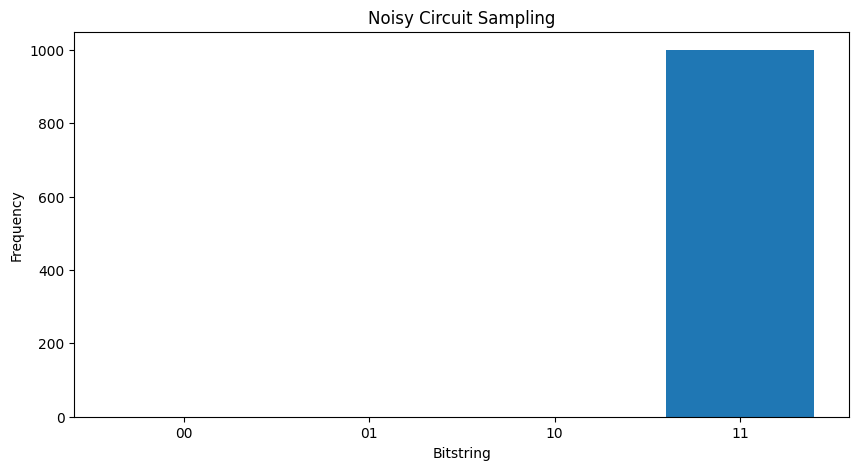

In [11]:
"""Sample from my_circuit."""
plot_samples(my_circuit)

If you increase the noise a little further it will become harder and harder to distinguish the desired behavior (sampling $|11\rangle$ ) from the noise:

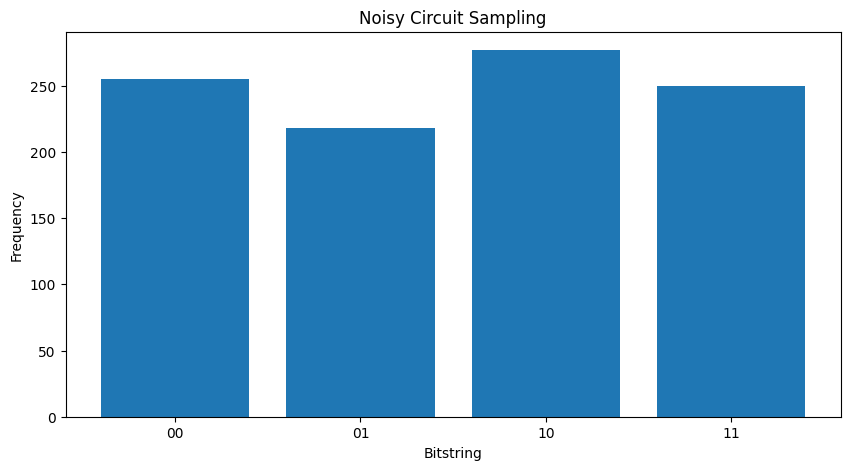

In [12]:
my_really_noisy_circuit = make_noisy(my_circuit, 0.75)
plot_samples(my_really_noisy_circuit)

Note: Try experimenting with different channels in your circuit to generate noise. Common channels supported in both Cirq and TFQ can be found [here](https://github.com/quantumlib/Cirq/blob/master/cirq-core/cirq/ops/common_channels.py)

## 2. Basic noise in TFQ
With this understanding of how noise can impact circuit execution, you can explore how noise works in TFQ. TensorFlow Quantum uses monte-carlo / trajectory based simulation as an alternative to density matrix simulation. This is because the memory complexity of density matrix simulation limits large simulations to being <= 20 qubits with traditional full density matrix simulation methods. Monte-carlo / trajectory trades this cost in memory for additional cost in time. The `backend='noisy'` option available to all `tfq.layers.Sample`, `tfq.layers.SampledExpectation` and `tfq.layers.Expectation` (In the case of `Expectation` this does add a required `repetitions` parameter).

### 2.1 Noisy sampling in TFQ
To recreate the above plots using TFQ and trajectory simulation you can use `tfq.layers.Sample`

In [13]:
"""Draw bitstring samples from `my_noisy_circuit`"""
bitstrings = tfq.layers.Sample(backend='noisy')(my_noisy_circuit, repetitions=1000)

<BarContainer object of 4 artists>

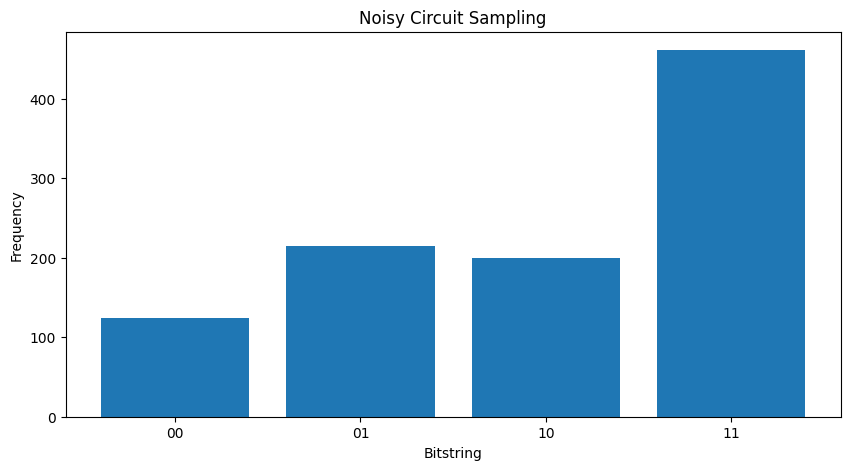

In [14]:
numeric_values = np.einsum('ijk,k->ij', bitstrings.to_tensor().numpy(), [1, 2])[0]
freqs, _ = np.histogram(numeric_values, bins=[i+0.01 for i in range(-1,2** len(my_qubits))])
plt.figure(figsize=(10,5))
plt.title('Noisy Circuit Sampling')
plt.xlabel('Bitstring')
plt.ylabel('Frequency')
plt.bar([i for i in range(2** len(my_qubits))], freqs, tick_label=['00','01','10','11'])

### 2.2 Noisy sample based expectation
To do noisy sample based expectation calculation you can use `tfq.layers.SampleExpectation`:


In [15]:
some_observables = [cirq.X(my_qubits[0]), cirq.Z(my_qubits[0]), 3.0 * cirq.Y(my_qubits[1]) + 1]
some_observables

[cirq.X(cirq.GridQubit(0, 0)),
 cirq.Z(cirq.GridQubit(0, 0)),
 cirq.PauliSum(cirq.LinearDict({frozenset({(cirq.GridQubit(0, 1), cirq.Y)}): (3+0j), frozenset(): (1+0j)}))]

Compute the noiseless expectation estimates via sampling from the circuit:

In [16]:
noiseless_sampled_expectation = tfq.layers.SampledExpectation(backend='noiseless')(
    my_circuit, operators=some_observables, repetitions=10000
)
noiseless_sampled_expectation.numpy()

array([[-0.0046, -1.    ,  0.9754]], dtype=float32)

Compare those with the noisy versions:

In [17]:
noisy_sampled_expectation = tfq.layers.SampledExpectation(backend='noisy')(
    [my_noisy_circuit, my_really_noisy_circuit], operators=some_observables, repetitions=10000
)
noisy_sampled_expectation.numpy()

array([[ 0.005    , -0.3302   ,  1.0126   ],
       [-0.0132   , -0.0292   ,  1.0029999]], dtype=float32)

You can see that the noise has particularly impacted the $\langle \psi | Z | \psi \rangle$ accuracy, with `my_really_noisy_circuit` concentrating very quickly towards 0.

### 2.3 Noisy analytic expectation calculation
Doing noisy analytic expectation calculations is nearly identical to above:



In [18]:
noiseless_analytic_expectation = tfq.layers.Expectation(backend='noiseless')(
    my_circuit, operators=some_observables
)
noiseless_analytic_expectation.numpy()

array([[ 1.9106853e-15, -1.0000000e+00,  1.0000002e+00]], dtype=float32)

In [19]:
noisy_analytic_expectation = tfq.layers.Expectation(backend='noisy')(
    [my_noisy_circuit, my_really_noisy_circuit], operators=some_observables, repetitions=10000
)
noisy_analytic_expectation.numpy()

array([[ 1.9106855e-15, -3.2699999e-01,  1.0000000e+00],
       [ 1.9106855e-15,  1.1399999e-02,  1.0000000e+00]], dtype=float32)

## 3. Hybrid models and quantum data noise
Now that you have implemented some noisy circuit simulations in TFQ, you can experiment with how noise impacts quantum and hybrid quantum classical models, by comparing and contrasting their noisy vs noiseless performance. A good first check to see if a model or algorithm is robust to noise is to test under a circuit wide depolarizing model which looks something like this:

<img src="./images/noise_2.png" width=500>

Where each time slice of the circuit (sometimes referred to as moment) has a depolarizing channel appended after each gate operation in that time slice. The depolarizing channel with apply one of $\{X, Y, Z \}$ with probability $p$ or apply nothing (keep the original operation) with probability $1-p$.

### 3.1 Data
For this example you can use some prepared circuits in the `tfq.datasets` module as training data:

In [20]:
qubits = cirq.GridQubit.rect(1, 8)
circuits, labels, pauli_sums, _ = tfq.datasets.xxz_chain(qubits, 'closed')
circuits[0]


    16384/184449737 [..............................] - ETA: 0s


  4202496/184449737 [..............................] - ETA: 6s


 10305536/184449737 [>.............................] - ETA: 3s


 16785408/184449737 [=>............................] - ETA: 2s


 25174016/184449737 [===>..........................] - ETA: 2s


 33562624/184449737 [====>.........................] - ETA: 1s


 41951232/184449737 [=====>........................] - ETA: 1s


 49512448/184449737 [=======>......................] - ETA: 1s


 54435840/184449737 [=======>......................] - ETA: 1s


 58957824/184449737 [========>.....................] - ETA: 1s


 66863104/184449737 [=========>....................] - ETA: 1s


 70893568/184449737 [==========>...................] - ETA: 1s


 79675392/184449737 [===========>..................] - ETA: 1s


 83894272/184449737 [============>.................] - ETA: 1s


 92282880/184449737 [==============>...............] - ETA: 0s


100671488/184449737 [===============>..............] - ETA: 0s


109060096/184449737 [================>.............] - ETA: 0s


118464512/184449737 [==================>...........] - ETA: 0s


125837312/184449737 [===================>..........] - ETA: 0s


135806976/184449737 [=====================>........] - ETA: 0s


143482880/184449737 [======================>.......] - ETA: 0s


150798336/184449737 [=======================>......] - ETA: 0s


158638080/184449737 [========================>.....] - ETA: 0s


159391744/184449737 [========================>.....] - ETA: 0s


170762240/184449737 [==========================>...] - ETA: 0s


176168960/184449737 [===========================>..] - ETA: 0s


182583296/184449737 [============================>.] - ETA: 0s


184451072/184449737 [==============================] - 2s 0us/step



184459264/184449737 [==============================] - 2s 0us/step


┌──────────────────┐   ┌──────────────────────┐   ┌──────────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌──────────────────┐                                        ┌──────────────────┐   ┌──────────────────┐   ┌──────────────────┐                                        ┌──────────────────┐   ┌──────────────────┐   ┌──────────────────┐
(0, 0): ───X───H───@─────────────ZZ───────────────────────YY─────────────────────────XX─────────────ZZ──────────YY──────────XX────────────────────ZZ─────────────────────YY─────────────────────XX───────────ZZ─────────YY───────────XX─────────────────────ZZ─────────────────────YY─────────────────────XX───────────ZZ─────────YY───────────XX─────────────────────ZZ─────────────────────YY─────────────────────XX───────────ZZ──────────YY──────────XX──────────
                   │             │                        │                          │              │           │           │                     │                      │                      │            │          │            │                      │                      │                      │            │          │            │                      │                      │                      │            │           │           │
(0, 1): ───X───────X────ZZ───────┼─────────────YY─────────┼───────────────XX─────────┼──────────────ZZ^-0.941───YY^-0.767───XX^-0.767────ZZ───────┼─────────────YY───────┼─────────────XX───────┼────────────ZZ^-0.98───YY^(-9/11)───XX^(-9/11)────ZZ───────┼─────────────YY───────┼─────────────XX───────┼────────────ZZ^-0.98───YY^(-9/11)───XX^(-9/11)────ZZ───────┼─────────────YY───────┼─────────────XX───────┼────────────ZZ^-0.985───YY^-0.901───XX^-0.901───
                        │        │             │          │               │          │                                                   │        │             │        │             │        │                                                  │        │             │        │             │        │                                                  │        │             │        │             │        │
(0, 2): ───X───H───@────ZZ^-0.977┼─────────────YY^(-10/11)┼───────────────XX^(-10/11)┼──────────────ZZ──────────YY──────────XX───────────ZZ^-0.968┼─────────────YY^-0.898┼─────────────XX^-0.898┼────────────ZZ─────────YY───────────XX────────────ZZ^-0.962┼─────────────YY^-0.869┼─────────────XX^-0.869┼────────────ZZ─────────YY───────────XX────────────ZZ^-0.954┼─────────────YY^-0.904┼─────────────XX^-0.904┼────────────ZZ──────────YY──────────XX──────────
                   │             │                        │                          │              │           │           │                     │                      │                      │            │          │            │                      │                      │                      │            │          │            │                      │                      │                      │            │           │           │
(0, 3): ───X───────X────ZZ───────┼─────────────YY─────────┼───────────────XX─────────┼──────────────ZZ^-0.941───YY^-0.767───XX^-0.767────ZZ───────┼─────────────YY───────┼─────────────XX───────┼────────────ZZ^-0.98───YY^(-9/11)───XX^(-9/11)────ZZ───────┼─────────────YY───────┼─────────────XX───────┼────────────ZZ^-0.98───YY^(-9/11)───XX^(-9/11)────ZZ───────┼─────────────YY───────┼─────────────XX───────┼────────────ZZ^-0.985───YY^-0.901───XX^-0.901───
                        │        │             │          │               │          │                                                   │        │             │        │             │        │                                                  │        │             │        │             │        │                                                  │        │             │        │             │        │
(0, 4): ───X───H───@────ZZ^-0.977┼─────────────YY^(-10/11)┼───────────────XX^(-10/11)┼────────

Writing a small helper function will help to generate the data for the noisy vs noiseless case:

In [21]:
def get_data(qubits, depolarize_p=0.):
  """Return quantum data circuits and labels in `tf.Tensor` form."""
  circuits, labels, pauli_sums, _ = tfq.datasets.xxz_chain(qubits, 'closed')
  if depolarize_p >= 1e-5:
    circuits = [circuit.with_noise(cirq.depolarize(depolarize_p)) for circuit in circuits]
  tmp = list(zip(circuits, labels))
  random.shuffle(tmp)
  circuits_tensor = tfq.convert_to_tensor([x[0] for x in tmp])
  labels_tensor = tf.convert_to_tensor([x[1] for x in tmp])

  return circuits_tensor, labels_tensor

### 3.2 Define a model circuit
Now that you have quantum data in the form of circuits, you will need a circuit to model this data, like with the data you can write a helper function to generate this circuit optionally containing noise:

In [22]:
def modelling_circuit(qubits, depth, depolarize_p=0.):
  """A simple classifier circuit."""
  dim = len(qubits)
  ret = cirq.Circuit(cirq.H.on_each(*qubits))

  for i in range(depth):
    # Entangle layer.
    ret += cirq.Circuit(cirq.CX(q1, q2) for (q1, q2) in zip(qubits[::2], qubits[1::2]))
    ret += cirq.Circuit(cirq.CX(q1, q2) for (q1, q2) in zip(qubits[1::2], qubits[2::2]))
    # Learnable rotation layer.
    # i_params = sympy.symbols(f'layer-{i}-0:{dim}')
    param = sympy.Symbol(f'layer-{i}')
    single_qb = cirq.X
    if i % 2 == 1:
      single_qb = cirq.Y
    ret += cirq.Circuit(single_qb(q) ** param for q in qubits)
  
  if depolarize_p >= 1e-5:
    ret = ret.with_noise(cirq.depolarize(depolarize_p))

  return ret, [op(q) for q in qubits for op in [cirq.X, cirq.Y, cirq.Z]]

modelling_circuit(qubits, 3)[0]

(0, 0): ───H───@───────X^(layer-0)───@───────Y^(layer-1)───@───────X^(layer-2)───
               │                     │                     │
(0, 1): ───H───X───@───X^(layer-0)───X───@───Y^(layer-1)───X───@───X^(layer-2)───
                   │                     │                     │
(0, 2): ───H───@───X───X^(layer-0)───@───X───Y^(layer-1)───@───X───X^(layer-2)───
               │                     │                     │
(0, 3): ───H───X───@───X^(layer-0)───X───@───Y^(layer-1)───X───@───X^(layer-2)───
                   │                     │                     │
(0, 4): ───H───@───X───X^(layer-0)───@───X───Y^(layer-1)───@───X───X^(layer-2)───
               │                     │                     │
(0, 5): ───H───X───@───X^(layer-0)───X───@───Y^(layer-1)───X───@───X^(layer-2)───
                   │                     │                     │
(0, 6): ───H───@───X───X^(layer-0)───@───X───Y^(layer-1)───@───X───X^(layer-2)───
               │                     │                     │
(0, 7): ───H───X───────X^(layer-0)───X───────Y^(layer-1)───X───────X^(layer-2)───

### 3.3 Model building and training
With your data and model circuit built, the final helper function you will need is one that can assemble both a noisy or a noiseless hybrid quantum `tf.keras.Model`:

In [23]:
def build_keras_model(qubits, depolarize_p=0.):
  """Prepare a noisy hybrid quantum classical Keras model."""
  spin_input = tf.keras.Input(shape=(), dtype=tf.dtypes.string)

  circuit_and_readout = modelling_circuit(qubits, 4, depolarize_p)
  if depolarize_p >= 1e-5:
    quantum_model = tfq.layers.NoisyPQC(*circuit_and_readout, sample_based=False, repetitions=10)(spin_input)
  else:
    quantum_model = tfq.layers.PQC(*circuit_and_readout)(spin_input)

  intermediate = tf.keras.layers.Dense(4, activation='sigmoid')(quantum_model)
  post_process = tf.keras.layers.Dense(1)(intermediate)

  return tf.keras.Model(inputs=[spin_input], outputs=[post_process])

## 4. Compare performance

### 4.1 Noiseless baseline

With your data generation and model building code, you can now compare and contrast model performance in the noiseless and noisy settings, first you can run a reference noiseless training:

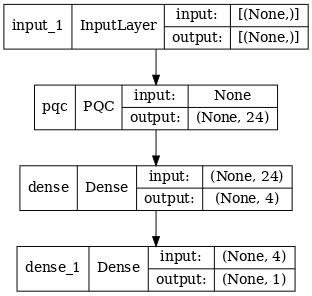

In [24]:
training_histories = dict()
depolarize_p = 0.
n_epochs = 50
phase_classifier = build_keras_model(qubits, depolarize_p)

phase_classifier.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.02),
                   loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                   metrics=['accuracy'])


# Show the keras plot of the model
tf.keras.utils.plot_model(phase_classifier, show_shapes=True, dpi=70)

In [25]:
noiseless_data, noiseless_labels = get_data(qubits, depolarize_p)
training_histories['noiseless'] = phase_classifier.fit(x=noiseless_data,
                         y=noiseless_labels,
                         batch_size=16,
                         epochs=n_epochs,
                         validation_split=0.15,
                         verbose=1)

Epoch 1/50



1/4 [======>.......................] - ETA: 1s - loss: 0.6258 - accuracy: 0.6875


2/4 [==============>...............] - ETA: 0s - loss: 0.8221 - accuracy: 0.4688


3/4 [=====================>........] - ETA: 0s - loss: 0.7718 - accuracy: 0.5208


4/4 [==============================] - ETA: 0s - loss: 0.7575 - accuracy: 0.5312


4/4 [==============================] - 1s 149ms/step - loss: 0.7575 - accuracy: 0.5312 - val_loss: 0.7520 - val_accuracy: 0.5000


Epoch 2/50

1/4 [======>.......................] - ETA: 0s - loss: 0.6624 - accuracy: 0.6250


2/4 [==============>...............] - ETA: 0s - loss: 0.7022 - accuracy: 0.5625


3/4 [=====================>........] - ETA: 0s - loss: 0.7251 - accuracy: 0.5208


4/4 [==============================] - ETA: 0s - loss: 0.7162 - accuracy: 0.5312


4/4 [==============================] - 0s 89ms/step - loss: 0.7162 - accuracy: 0.5312 - val_loss: 0.7165 - val_accuracy: 1.0000


Epoch 3/50



1/4 [======>.......................] - ETA: 0s - loss: 0.7165 - accuracy: 0.9375


2/4 [==============>...............] - ETA: 0s - loss: 0.7132 - accuracy: 0.7188


3/4 [=====================>........] - ETA: 0s - loss: 0.6937 - accuracy: 0.6042


4/4 [==============================] - ETA: 0s - loss: 0.6951 - accuracy: 0.5781


4/4 [==============================] - 0s 88ms/step - loss: 0.6951 - accuracy: 0.5781 - val_loss: 0.6956 - val_accuracy: 0.5000


Epoch 4/50



1/4 [======>.......................] - ETA: 0s - loss: 0.6777 - accuracy: 0.4375


2/4 [==============>...............] - ETA: 0s - loss: 0.6491 - accuracy: 0.3438


3/4 [=====================>........] - ETA: 0s - loss: 0.6739 - accuracy: 0.4375


4/4 [==============================] - ETA: 0s - loss: 0.6812 - accuracy: 0.4688


4/4 [==============================] - 0s 84ms/step - loss: 0.6812 - accuracy: 0.4688 - val_loss: 0.6855 - val_accuracy: 0.5000


Epoch 5/50



1/4 [======>.......................] - ETA: 0s - loss: 0.6845 - accuracy: 0.5000


2/4 [==============>...............] - ETA: 0s - loss: 0.6775 - accuracy: 0.4688


3/4 [=====================>........] - ETA: 0s - loss: 0.6796 - accuracy: 0.4792


4/4 [==============================] - ETA: 0s - loss: 0.6777 - accuracy: 0.4688


4/4 [==============================] - 0s 86ms/step - loss: 0.6777 - accuracy: 0.4688 - val_loss: 0.6775 - val_accuracy: 0.5000


Epoch 6/50



1/4 [======>.......................] - ETA: 0s - loss: 0.6843 - accuracy: 0.5625


2/4 [==============>...............] - ETA: 0s - loss: 0.6861 - accuracy: 0.5938




3/4 [=====================>........] - ETA: 0s - loss: 0.6808 - accuracy: 0.5417


4/4 [==============================] - ETA: 0s - loss: 0.6745 - accuracy: 0.4688


4/4 [==============================] - 0s 84ms/step - loss: 0.6745 - accuracy: 0.4688 - val_loss: 0.6692 - val_accuracy: 0.5000


Epoch 7/50



1/4 [======>.......................] - ETA: 0s - loss: 0.6735 - accuracy: 0.5000


2/4 [==============>...............] - ETA: 0s - loss: 0.6699 - accuracy: 0.5312


3/4 [=====================>........] - ETA: 0s - loss: 0.6632 - accuracy: 0.4583


4/4 [==============================] - ETA: 0s - loss: 0.6634 - accuracy: 0.4688


4/4 [==============================] - 0s 84ms/step - loss: 0.6634 - accuracy: 0.4688 - val_loss: 0.6599 - val_accuracy: 0.5000


Epoch 8/50



1/4 [======>.......................] - ETA: 0s - loss: 0.6445 - accuracy: 0.3125


2/4 [==============>...............] - ETA: 0s - loss: 0.6657 - accuracy: 0.5000


3/4 [=====================>........] - ETA: 0s - loss: 0.6627 - accuracy: 0.5000


4/4 [==============================] - ETA: 0s - loss: 0.6540 - accuracy: 0.4688


4/4 [==============================] - 0s 83ms/step - loss: 0.6540 - accuracy: 0.4688 - val_loss: 0.6540 - val_accuracy: 0.5000


Epoch 9/50



1/4 [======>.......................] - ETA: 0s - loss: 0.6650 - accuracy: 0.5625


2/4 [==============>...............] - ETA: 0s - loss: 0.6639 - accuracy: 0.5312


3/4 [=====================>........] - ETA: 0s - loss: 0.6587 - accuracy: 0.5208


4/4 [==============================] - ETA: 0s - loss: 0.6462 - accuracy: 0.4688


4/4 [==============================] - 0s 85ms/step - loss: 0.6462 - accuracy: 0.4688 - val_loss: 0.6478 - val_accuracy: 0.5000


Epoch 10/50



1/4 [======>.......................] - ETA: 0s - loss: 0.6175 - accuracy: 0.3125


2/4 [==============>...............] - ETA: 0s - loss: 0.6398 - accuracy: 0.4375


3/4 [=====================>........] - ETA: 0s - loss: 0.6350 - accuracy: 0.4375


4/4 [==============================] - ETA: 0s - loss: 0.6402 - accuracy: 0.4688


4/4 [==============================] - 0s 84ms/step - loss: 0.6402 - accuracy: 0.4688 - val_loss: 0.6397 - val_accuracy: 0.5000


Epoch 11/50



1/4 [======>.......................] - ETA: 0s - loss: 0.6283 - accuracy: 0.5000


2/4 [==============>...............] - ETA: 0s - loss: 0.6324 - accuracy: 0.5000


3/4 [=====================>........] - ETA: 0s - loss: 0.6316 - accuracy: 0.5417


4/4 [==============================] - ETA: 0s - loss: 0.6290 - accuracy: 0.5312


4/4 [==============================] - 0s 84ms/step - loss: 0.6290 - accuracy: 0.5312 - val_loss: 0.6271 - val_accuracy: 0.5000


Epoch 12/50



1/4 [======>.......................] - ETA: 0s - loss: 0.6604 - accuracy: 0.7500


2/4 [==============>...............] - ETA: 0s - loss: 0.6460 - accuracy: 0.7188


3/4 [=====================>........] - ETA: 0s - loss: 0.6282 - accuracy: 0.5833


4/4 [==============================] - ETA: 0s - loss: 0.6224 - accuracy: 0.5156


4/4 [==============================] - 0s 84ms/step - loss: 0.6224 - accuracy: 0.5156 - val_loss: 0.6151 - val_accuracy: 0.5000


Epoch 13/50



1/4 [======>.......................] - ETA: 0s - loss: 0.6289 - accuracy: 0.6875


2/4 [==============>...............] - ETA: 0s - loss: 0.6137 - accuracy: 0.6250


3/4 [=====================>........] - ETA: 0s - loss: 0.6175 - accuracy: 0.6042


4/4 [==============================] - ETA: 0s - loss: 0.6073 - accuracy: 0.5312


4/4 [==============================] - 0s 83ms/step - loss: 0.6073 - accuracy: 0.5312 - val_loss: 0.6014 - val_accuracy: 0.5000


Epoch 14/50



1/4 [======>.......................] - ETA: 0s - loss: 0.6178 - accuracy: 0.8750


2/4 [==============>...............] - ETA: 0s - loss: 0.6009 - accuracy: 0.6875


3/4 [=====================>........] - ETA: 0s - loss: 0.5881 - accuracy: 0.6667




4/4 [==============================] - ETA: 0s - loss: 0.5928 - accuracy: 0.6875


4/4 [==============================] - 0s 86ms/step - loss: 0.5928 - accuracy: 0.6875 - val_loss: 0.5898 - val_accuracy: 0.9167


Epoch 15/50



1/4 [======>.......................] - ETA: 0s - loss: 0.6020 - accuracy: 0.8125


2/4 [==============>...............] - ETA: 0s - loss: 0.5918 - accuracy: 0.7188


3/4 [=====================>........] - ETA: 0s - loss: 0.6004 - accuracy: 0.7500


4/4 [==============================] - ETA: 0s - loss: 0.5797 - accuracy: 0.7344


4/4 [==============================] - 0s 84ms/step - loss: 0.5797 - accuracy: 0.7344 - val_loss: 0.5729 - val_accuracy: 0.9167


Epoch 16/50



1/4 [======>.......................] - ETA: 0s - loss: 0.6039 - accuracy: 0.8125


2/4 [==============>...............] - ETA: 0s - loss: 0.5945 - accuracy: 0.7500


3/4 [=====================>........] - ETA: 0s - loss: 0.5722 - accuracy: 0.7500


4/4 [==============================] - ETA: 0s - loss: 0.5631 - accuracy: 0.7656


4/4 [==============================] - 0s 83ms/step - loss: 0.5631 - accuracy: 0.7656 - val_loss: 0.5536 - val_accuracy: 0.9167


Epoch 17/50



1/4 [======>.......................] - ETA: 0s - loss: 0.5448 - accuracy: 0.6875


2/4 [==============>...............] - ETA: 0s - loss: 0.5585 - accuracy: 0.7500


3/4 [=====================>........] - ETA: 0s - loss: 0.5438 - accuracy: 0.7917


4/4 [==============================] - ETA: 0s - loss: 0.5448 - accuracy: 0.8125


4/4 [==============================] - 0s 83ms/step - loss: 0.5448 - accuracy: 0.8125 - val_loss: 0.5344 - val_accuracy: 0.9167


Epoch 18/50



1/4 [======>.......................] - ETA: 0s - loss: 0.5551 - accuracy: 0.7500


2/4 [==============>...............] - ETA: 0s - loss: 0.5478 - accuracy: 0.8438


3/4 [=====================>........] - ETA: 0s - loss: 0.5451 - accuracy: 0.8542


4/4 [==============================] - ETA: 0s - loss: 0.5260 - accuracy: 0.8438


4/4 [==============================] - 0s 84ms/step - loss: 0.5260 - accuracy: 0.8438 - val_loss: 0.5129 - val_accuracy: 0.9167


Epoch 19/50



1/4 [======>.......................] - ETA: 0s - loss: 0.5127 - accuracy: 0.8750


2/4 [==============>...............] - ETA: 0s - loss: 0.5237 - accuracy: 0.8125


3/4 [=====================>........] - ETA: 0s - loss: 0.5281 - accuracy: 0.8333


4/4 [==============================] - ETA: 0s - loss: 0.5070 - accuracy: 0.8438


4/4 [==============================] - 0s 85ms/step - loss: 0.5070 - accuracy: 0.8438 - val_loss: 0.4908 - val_accuracy: 0.9167


Epoch 20/50



1/4 [======>.......................] - ETA: 0s - loss: 0.5255 - accuracy: 0.7500


2/4 [==============>...............] - ETA: 0s - loss: 0.5071 - accuracy: 0.7812


3/4 [=====================>........] - ETA: 0s - loss: 0.4839 - accuracy: 0.8125


4/4 [==============================] - ETA: 0s - loss: 0.4870 - accuracy: 0.8438


4/4 [==============================] - 0s 83ms/step - loss: 0.4870 - accuracy: 0.8438 - val_loss: 0.4695 - val_accuracy: 1.0000


Epoch 21/50



1/4 [======>.......................] - ETA: 0s - loss: 0.5255 - accuracy: 0.8750


2/4 [==============>...............] - ETA: 0s - loss: 0.5019 - accuracy: 0.8438


3/4 [=====================>........] - ETA: 0s - loss: 0.4724 - accuracy: 0.8542


4/4 [==============================] - ETA: 0s - loss: 0.4664 - accuracy: 0.8594


4/4 [==============================] - 0s 84ms/step - loss: 0.4664 - accuracy: 0.8594 - val_loss: 0.4449 - val_accuracy: 1.0000


Epoch 22/50



1/4 [======>.......................] - ETA: 0s - loss: 0.4252 - accuracy: 0.8125


2/4 [==============>...............] - ETA: 0s - loss: 0.4479 - accuracy: 0.8125


3/4 [=====================>........] - ETA: 0s - loss: 0.4379 - accuracy: 0.8750


4/4 [==============================] - ETA: 0s - loss: 0.4458 - accuracy: 0.8594


4/4 [==============================] - 0s 86ms/step - loss: 0.4458 - accuracy: 0.8594 - val_loss: 0.4208 - val_accuracy: 1.0000


Epoch 23/50



1/4 [======>.......................] - ETA: 0s - loss: 0.4237 - accuracy: 0.8750


2/4 [==============>...............] - ETA: 0s - loss: 0.4316 - accuracy: 0.9375


3/4 [=====================>........] - ETA: 0s - loss: 0.4333 - accuracy: 0.8958


4/4 [==============================] - ETA: 0s - loss: 0.4257 - accuracy: 0.8750


4/4 [==============================] - 0s 84ms/step - loss: 0.4257 - accuracy: 0.8750 - val_loss: 0.3970 - val_accuracy: 1.0000


Epoch 24/50



1/4 [======>.......................] - ETA: 0s - loss: 0.4569 - accuracy: 0.7500


2/4 [==============>...............] - ETA: 0s - loss: 0.4237 - accuracy: 0.8125


3/4 [=====================>........] - ETA: 0s - loss: 0.4217 - accuracy: 0.8542


4/4 [==============================] - ETA: 0s - loss: 0.4049 - accuracy: 0.8750


4/4 [==============================] - 0s 85ms/step - loss: 0.4049 - accuracy: 0.8750 - val_loss: 0.3756 - val_accuracy: 1.0000


Epoch 25/50



1/4 [======>.......................] - ETA: 0s - loss: 0.3399 - accuracy: 0.8750


2/4 [==============>...............] - ETA: 0s - loss: 0.3530 - accuracy: 0.8750


3/4 [=====================>........] - ETA: 0s - loss: 0.3830 - accuracy: 0.8958


4/4 [==============================] - ETA: 0s - loss: 0.3851 - accuracy: 0.9062


4/4 [==============================] - 0s 85ms/step - loss: 0.3851 - accuracy: 0.9062 - val_loss: 0.3532 - val_accuracy: 1.0000


Epoch 26/50



1/4 [======>.......................] - ETA: 0s - loss: 0.3649 - accuracy: 0.8750


2/4 [==============>...............] - ETA: 0s - loss: 0.3520 - accuracy: 0.8750


3/4 [=====================>........] - ETA: 0s - loss: 0.3489 - accuracy: 0.8958


4/4 [==============================] - ETA: 0s - loss: 0.3670 - accuracy: 0.9062


4/4 [==============================] - 0s 84ms/step - loss: 0.3670 - accuracy: 0.9062 - val_loss: 0.3330 - val_accuracy: 1.0000


Epoch 27/50



1/4 [======>.......................] - ETA: 0s - loss: 0.3527 - accuracy: 0.8750


2/4 [==============>...............] - ETA: 0s - loss: 0.3466 - accuracy: 0.9062


3/4 [=====================>........] - ETA: 0s - loss: 0.3565 - accuracy: 0.8958


4/4 [==============================] - ETA: 0s - loss: 0.3480 - accuracy: 0.9219


4/4 [==============================] - 0s 84ms/step - loss: 0.3480 - accuracy: 0.9219 - val_loss: 0.3121 - val_accuracy: 1.0000


Epoch 28/50



1/4 [======>.......................] - ETA: 0s - loss: 0.3283 - accuracy: 0.8750


2/4 [==============>...............] - ETA: 0s - loss: 0.3649 - accuracy: 0.8750


3/4 [=====================>........] - ETA: 0s - loss: 0.3516 - accuracy: 0.8958


4/4 [==============================] - ETA: 0s - loss: 0.3320 - accuracy: 0.9062


4/4 [==============================] - 0s 85ms/step - loss: 0.3320 - accuracy: 0.9062 - val_loss: 0.2924 - val_accuracy: 1.0000


Epoch 29/50



1/4 [======>.......................] - ETA: 0s - loss: 0.3774 - accuracy: 0.8750


2/4 [==============>...............] - ETA: 0s - loss: 0.3378 - accuracy: 0.8750


3/4 [=====================>........] - ETA: 0s - loss: 0.3073 - accuracy: 0.9167


4/4 [==============================] - ETA: 0s - loss: 0.3164 - accuracy: 0.9062


4/4 [==============================] - 0s 84ms/step - loss: 0.3164 - accuracy: 0.9062 - val_loss: 0.2769 - val_accuracy: 1.0000


Epoch 30/50



1/4 [======>.......................] - ETA: 0s - loss: 0.3247 - accuracy: 0.9375


2/4 [==============>...............] - ETA: 0s - loss: 0.3244 - accuracy: 0.9375


3/4 [=====================>........] - ETA: 0s - loss: 0.3085 - accuracy: 0.9167


4/4 [==============================] - ETA: 0s - loss: 0.3027 - accuracy: 0.9375


4/4 [==============================] - 0s 86ms/step - loss: 0.3027 - accuracy: 0.9375 - val_loss: 0.2614 - val_accuracy: 1.0000


Epoch 31/50



1/4 [======>.......................] - ETA: 0s - loss: 0.3105 - accuracy: 0.8750


2/4 [==============>...............] - ETA: 0s - loss: 0.2892 - accuracy: 0.9375


3/4 [=====================>........] - ETA: 0s - loss: 0.3059 - accuracy: 0.9167


4/4 [==============================] - ETA: 0s - loss: 0.2891 - accuracy: 0.9219


4/4 [==============================] - 0s 85ms/step - loss: 0.2891 - accuracy: 0.9219 - val_loss: 0.2437 - val_accuracy: 1.0000


Epoch 32/50



1/4 [======>.......................] - ETA: 0s - loss: 0.2252 - accuracy: 0.8750


2/4 [==============>...............] - ETA: 0s - loss: 0.2433 - accuracy: 0.9375


3/4 [=====================>........] - ETA: 0s - loss: 0.2775 - accuracy: 0.8958


4/4 [==============================] - ETA: 0s - loss: 0.2759 - accuracy: 0.9219


4/4 [==============================] - 0s 83ms/step - loss: 0.2759 - accuracy: 0.9219 - val_loss: 0.2296 - val_accuracy: 1.0000


Epoch 33/50



1/4 [======>.......................] - ETA: 0s - loss: 0.1940 - accuracy: 1.0000


2/4 [==============>...............] - ETA: 0s - loss: 0.2607 - accuracy: 0.9062


3/4 [=====================>........] - ETA: 0s - loss: 0.2503 - accuracy: 0.9375


4/4 [==============================] - ETA: 0s - loss: 0.2646 - accuracy: 0.9375


4/4 [==============================] - 0s 84ms/step - loss: 0.2646 - accuracy: 0.9375 - val_loss: 0.2209 - val_accuracy: 1.0000


Epoch 34/50



1/4 [======>.......................] - ETA: 0s - loss: 0.2869 - accuracy: 0.9375


2/4 [==============>...............] - ETA: 0s - loss: 0.2296 - accuracy: 0.9688


3/4 [=====================>........] - ETA: 0s - loss: 0.2384 - accuracy: 0.9375


4/4 [==============================] - ETA: 0s - loss: 0.2540 - accuracy: 0.9375


4/4 [==============================] - 0s 84ms/step - loss: 0.2540 - accuracy: 0.9375 - val_loss: 0.2056 - val_accuracy: 1.0000


Epoch 35/50



1/4 [======>.......................] - ETA: 0s - loss: 0.1739 - accuracy: 0.9375


2/4 [==============>...............] - ETA: 0s - loss: 0.2016 - accuracy: 0.9688


3/4 [=====================>........] - ETA: 0s - loss: 0.2236 - accuracy: 0.9375


4/4 [==============================] - ETA: 0s - loss: 0.2432 - accuracy: 0.9375


4/4 [==============================] - 0s 84ms/step - loss: 0.2432 - accuracy: 0.9375 - val_loss: 0.1937 - val_accuracy: 1.0000


Epoch 36/50



1/4 [======>.......................] - ETA: 0s - loss: 0.1660 - accuracy: 1.0000


2/4 [==============>...............] - ETA: 0s - loss: 0.2143 - accuracy: 0.9688


3/4 [=====================>........] - ETA: 0s - loss: 0.2296 - accuracy: 0.9375


4/4 [==============================] - ETA: 0s - loss: 0.2330 - accuracy: 0.9375


4/4 [==============================] - 0s 85ms/step - loss: 0.2330 - accuracy: 0.9375 - val_loss: 0.1857 - val_accuracy: 1.0000


Epoch 37/50



1/4 [======>.......................] - ETA: 0s - loss: 0.2848 - accuracy: 0.9375


2/4 [==============>...............] - ETA: 0s - loss: 0.2307 - accuracy: 0.9375


3/4 [=====================>........] - ETA: 0s - loss: 0.2260 - accuracy: 0.9375


4/4 [==============================] - ETA: 0s - loss: 0.2250 - accuracy: 0.9531


4/4 [==============================] - 0s 84ms/step - loss: 0.2250 - accuracy: 0.9531 - val_loss: 0.1761 - val_accuracy: 1.0000


Epoch 38/50



1/4 [======>.......................] - ETA: 0s - loss: 0.2031 - accuracy: 0.9375


2/4 [==============>...............] - ETA: 0s - loss: 0.1759 - accuracy: 0.9688


3/4 [=====================>........] - ETA: 0s - loss: 0.2033 - accuracy: 0.9583


4/4 [==============================] - ETA: 0s - loss: 0.2158 - accuracy: 0.9531


4/4 [==============================] - 0s 87ms/step - loss: 0.2158 - accuracy: 0.9531 - val_loss: 0.1659 - val_accuracy: 1.0000


Epoch 39/50



1/4 [======>.......................] - ETA: 0s - loss: 0.2391 - accuracy: 1.0000


2/4 [==============>...............] - ETA: 0s - loss: 0.2113 - accuracy: 0.9688


3/4 [=====================>........] - ETA: 0s - loss: 0.2064 - accuracy: 0.9583


4/4 [==============================] - ETA: 0s - loss: 0.2091 - accuracy: 0.9531


4/4 [==============================] - 0s 83ms/step - loss: 0.2091 - accuracy: 0.9531 - val_loss: 0.1578 - val_accuracy: 1.0000


Epoch 40/50



1/4 [======>.......................] - ETA: 0s - loss: 0.2403 - accuracy: 0.9375


2/4 [==============>...............] - ETA: 0s - loss: 0.1916 - accuracy: 0.9688


3/4 [=====================>........] - ETA: 0s - loss: 0.2098 - accuracy: 0.9167


4/4 [==============================] - ETA: 0s - loss: 0.2026 - accuracy: 0.9375


4/4 [==============================] - 0s 84ms/step - loss: 0.2026 - accuracy: 0.9375 - val_loss: 0.1503 - val_accuracy: 1.0000


Epoch 41/50



1/4 [======>.......................] - ETA: 0s - loss: 0.2019 - accuracy: 0.9375


2/4 [==============>...............] - ETA: 0s - loss: 0.1996 - accuracy: 0.9375


3/4 [=====================>........] - ETA: 0s - loss: 0.1950 - accuracy: 0.9375


4/4 [==============================] - ETA: 0s - loss: 0.1966 - accuracy: 0.9531


4/4 [==============================] - 0s 85ms/step - loss: 0.1966 - accuracy: 0.9531 - val_loss: 0.1478 - val_accuracy: 1.0000


Epoch 42/50



1/4 [======>.......................] - ETA: 0s - loss: 0.2638 - accuracy: 0.8750


2/4 [==============>...............] - ETA: 0s - loss: 0.2365 - accuracy: 0.9375




3/4 [=====================>........] - ETA: 0s - loss: 0.2153 - accuracy: 0.9583


4/4 [==============================] - ETA: 0s - loss: 0.1895 - accuracy: 0.9688


4/4 [==============================] - 0s 84ms/step - loss: 0.1895 - accuracy: 0.9688 - val_loss: 0.1389 - val_accuracy: 1.0000


Epoch 43/50



1/4 [======>.......................] - ETA: 0s - loss: 0.2456 - accuracy: 0.8750


2/4 [==============>...............] - ETA: 0s - loss: 0.1938 - accuracy: 0.9375


3/4 [=====================>........] - ETA: 0s - loss: 0.1922 - accuracy: 0.9583


4/4 [==============================] - ETA: 0s - loss: 0.1840 - accuracy: 0.9531


4/4 [==============================] - 0s 84ms/step - loss: 0.1840 - accuracy: 0.9531 - val_loss: 0.1294 - val_accuracy: 1.0000


Epoch 44/50



1/4 [======>.......................] - ETA: 0s - loss: 0.1479 - accuracy: 1.0000


2/4 [==============>...............] - ETA: 0s - loss: 0.1692 - accuracy: 0.9375


3/4 [=====================>........] - ETA: 0s - loss: 0.1662 - accuracy: 0.9375


4/4 [==============================] - ETA: 0s - loss: 0.1824 - accuracy: 0.9531


4/4 [==============================] - 0s 85ms/step - loss: 0.1824 - accuracy: 0.9531 - val_loss: 0.1278 - val_accuracy: 1.0000


Epoch 45/50



1/4 [======>.......................] - ETA: 0s - loss: 0.2292 - accuracy: 0.9375


2/4 [==============>...............] - ETA: 0s - loss: 0.1760 - accuracy: 0.9375


3/4 [=====================>........] - ETA: 0s - loss: 0.1818 - accuracy: 0.9583


4/4 [==============================] - ETA: 0s - loss: 0.1738 - accuracy: 0.9531


4/4 [==============================] - 0s 85ms/step - loss: 0.1738 - accuracy: 0.9531 - val_loss: 0.1209 - val_accuracy: 1.0000


Epoch 46/50



1/4 [======>.......................] - ETA: 0s - loss: 0.1522 - accuracy: 0.8750


2/4 [==============>...............] - ETA: 0s - loss: 0.1697 - accuracy: 0.9375


3/4 [=====================>........] - ETA: 0s - loss: 0.1687 - accuracy: 0.9583


4/4 [==============================] - ETA: 0s - loss: 0.1707 - accuracy: 0.9531


4/4 [==============================] - 0s 83ms/step - loss: 0.1707 - accuracy: 0.9531 - val_loss: 0.1146 - val_accuracy: 1.0000


Epoch 47/50



1/4 [======>.......................] - ETA: 0s - loss: 0.1464 - accuracy: 0.9375


2/4 [==============>...............] - ETA: 0s - loss: 0.1744 - accuracy: 0.9688


3/4 [=====================>........] - ETA: 0s - loss: 0.1712 - accuracy: 0.9583


4/4 [==============================] - ETA: 0s - loss: 0.1655 - accuracy: 0.9688


4/4 [==============================] - 0s 84ms/step - loss: 0.1655 - accuracy: 0.9688 - val_loss: 0.1131 - val_accuracy: 1.0000


Epoch 48/50



1/4 [======>.......................] - ETA: 0s - loss: 0.2003 - accuracy: 1.0000


2/4 [==============>...............] - ETA: 0s - loss: 0.1581 - accuracy: 0.9688


3/4 [=====================>........] - ETA: 0s - loss: 0.1601 - accuracy: 0.9792


4/4 [==============================] - ETA: 0s - loss: 0.1638 - accuracy: 0.9531


4/4 [==============================] - 0s 84ms/step - loss: 0.1638 - accuracy: 0.9531 - val_loss: 0.1049 - val_accuracy: 1.0000


Epoch 49/50



1/4 [======>.......................] - ETA: 0s - loss: 0.1266 - accuracy: 0.9375


2/4 [==============>...............] - ETA: 0s - loss: 0.1269 - accuracy: 0.9688


3/4 [=====================>........] - ETA: 0s - loss: 0.1416 - accuracy: 0.9583


4/4 [==============================] - ETA: 0s - loss: 0.1567 - accuracy: 0.9531


4/4 [==============================] - 0s 84ms/step - loss: 0.1567 - accuracy: 0.9531 - val_loss: 0.1058 - val_accuracy: 1.0000


Epoch 50/50



1/4 [======>.......................] - ETA: 0s - loss: 0.0715 - accuracy: 1.0000


2/4 [==============>...............] - ETA: 0s - loss: 0.1330 - accuracy: 1.0000


3/4 [=====================>........] - ETA: 0s - loss: 0.1521 - accuracy: 0.9792


4/4 [==============================] - ETA: 0s - loss: 0.1553 - accuracy: 0.9531


4/4 [==============================] - 0s 86ms/step - loss: 0.1553 - accuracy: 0.9531 - val_loss: 0.0992 - val_accuracy: 1.0000


And explore the results and accuracy:

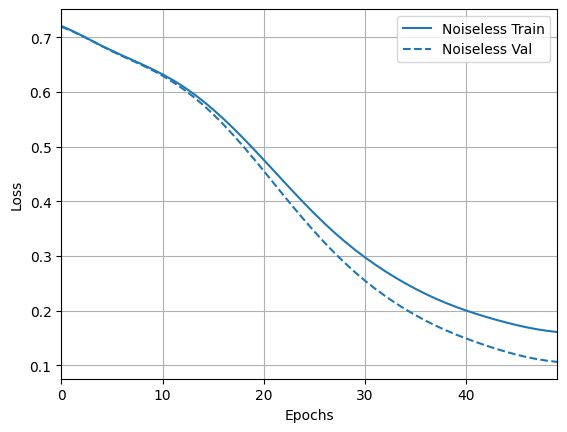

In [26]:
loss_plotter = tfdocs.plots.HistoryPlotter(metric = 'loss', smoothing_std=10)
loss_plotter.plot(training_histories)

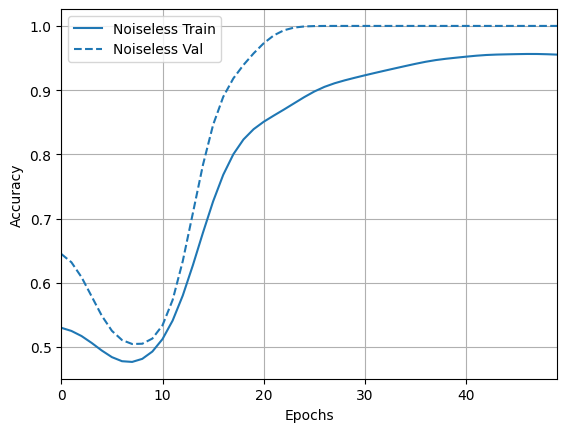

In [27]:
acc_plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy', smoothing_std=10)
acc_plotter.plot(training_histories)

### 4.2 Noisy comparison
Now you can build a new model with noisy structure and compare to the above, the code is nearly identical:

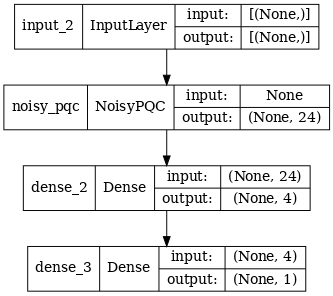

In [28]:
depolarize_p = 0.001
n_epochs = 50
noisy_phase_classifier = build_keras_model(qubits, depolarize_p)

noisy_phase_classifier.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.02),
                   loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                   metrics=['accuracy'])


# Show the keras plot of the model
tf.keras.utils.plot_model(noisy_phase_classifier, show_shapes=True, dpi=70)

Note: in the model diagram there is now a `tfq.layers.NoisyPQC` instead of a `tfq.layers.PQC` since the depolarization probability is no longer zero. Training will take significantly longer since noisy simulation is far more expensive than noiseless.

In [29]:
noisy_data, noisy_labels = get_data(qubits, depolarize_p)
training_histories['noisy'] = noisy_phase_classifier.fit(x=noisy_data,
                         y=noisy_labels,
                         batch_size=16,
                         epochs=n_epochs,
                         validation_split=0.15,
                         verbose=1)

Epoch 1/50



1/4 [======>.......................] - ETA: 15s - loss: 0.5547 - accuracy: 0.1250


2/4 [==============>...............] - ETA: 3s - loss: 0.6532 - accuracy: 0.4375 


3/4 [=====================>........] - ETA: 1s - loss: 0.7189 - accuracy: 0.3958


4/4 [==============================] - ETA: 0s - loss: 0.7105 - accuracy: 0.4844


4/4 [==============================] - 11s 2s/step - loss: 0.7105 - accuracy: 0.4844 - val_loss: 0.7093 - val_accuracy: 0.6667


Epoch 2/50



1/4 [======>.......................] - ETA: 5s - loss: 0.7373 - accuracy: 0.6250


2/4 [==============>...............] - ETA: 3s - loss: 0.7459 - accuracy: 0.6250


3/4 [=====================>........] - ETA: 1s - loss: 0.6976 - accuracy: 0.5000


4/4 [==============================] - ETA: 0s - loss: 0.6905 - accuracy: 0.4844


4/4 [==============================] - 7s 2s/step - loss: 0.6905 - accuracy: 0.4844 - val_loss: 0.6903 - val_accuracy: 0.5000


Epoch 3/50



1/4 [======>.......................] - ETA: 4s - loss: 0.7305 - accuracy: 0.6250


2/4 [==============>...............] - ETA: 3s - loss: 0.6781 - accuracy: 0.4688


3/4 [=====================>........] - ETA: 1s - loss: 0.6744 - accuracy: 0.4583


4/4 [==============================] - ETA: 0s - loss: 0.6759 - accuracy: 0.4688


4/4 [==============================] - 7s 2s/step - loss: 0.6759 - accuracy: 0.4688 - val_loss: 0.6777 - val_accuracy: 0.5000


Epoch 4/50



1/4 [======>.......................] - ETA: 4s - loss: 0.7227 - accuracy: 0.6875


2/4 [==============>...............] - ETA: 3s - loss: 0.6721 - accuracy: 0.4688


3/4 [=====================>........] - ETA: 1s - loss: 0.6708 - accuracy: 0.4792


4/4 [==============================] - ETA: 0s - loss: 0.6664 - accuracy: 0.4688


4/4 [==============================] - 7s 2s/step - loss: 0.6664 - accuracy: 0.4688 - val_loss: 0.6682 - val_accuracy: 0.5000


Epoch 5/50



1/4 [======>.......................] - ETA: 4s - loss: 0.6345 - accuracy: 0.3750


2/4 [==============>...............] - ETA: 3s - loss: 0.6646 - accuracy: 0.5000


3/4 [=====================>........] - ETA: 1s - loss: 0.6559 - accuracy: 0.4583


4/4 [==============================] - ETA: 0s - loss: 0.6566 - accuracy: 0.4688


4/4 [==============================] - 7s 2s/step - loss: 0.6566 - accuracy: 0.4688 - val_loss: 0.6606 - val_accuracy: 0.5000


Epoch 6/50



1/4 [======>.......................] - ETA: 4s - loss: 0.6868 - accuracy: 0.6250


2/4 [==============>...............] - ETA: 3s - loss: 0.6649 - accuracy: 0.5312


3/4 [=====================>........] - ETA: 1s - loss: 0.6486 - accuracy: 0.4375


4/4 [==============================] - ETA: 0s - loss: 0.6527 - accuracy: 0.4688


4/4 [==============================] - 7s 2s/step - loss: 0.6527 - accuracy: 0.4688 - val_loss: 0.6507 - val_accuracy: 0.5000


Epoch 7/50



1/4 [======>.......................] - ETA: 4s - loss: 0.6384 - accuracy: 0.4375


2/4 [==============>...............] - ETA: 3s - loss: 0.6404 - accuracy: 0.4375


3/4 [=====================>........] - ETA: 1s - loss: 0.6424 - accuracy: 0.4792


4/4 [==============================] - ETA: 0s - loss: 0.6360 - accuracy: 0.4688


4/4 [==============================] - 7s 2s/step - loss: 0.6360 - accuracy: 0.4688 - val_loss: 0.6400 - val_accuracy: 0.5000


Epoch 8/50



1/4 [======>.......................] - ETA: 4s - loss: 0.6594 - accuracy: 0.6250


2/4 [==============>...............] - ETA: 3s - loss: 0.6528 - accuracy: 0.5938


3/4 [=====================>........] - ETA: 1s - loss: 0.6433 - accuracy: 0.5208


4/4 [==============================] - ETA: 0s - loss: 0.6350 - accuracy: 0.4688


4/4 [==============================] - 7s 2s/step - loss: 0.6350 - accuracy: 0.4688 - val_loss: 0.6314 - val_accuracy: 0.5000


Epoch 9/50



1/4 [======>.......................] - ETA: 4s - loss: 0.6343 - accuracy: 0.5625


2/4 [==============>...............] - ETA: 3s - loss: 0.6285 - accuracy: 0.5000


3/4 [=====================>........] - ETA: 1s - loss: 0.6279 - accuracy: 0.4583


4/4 [==============================] - ETA: 0s - loss: 0.6206 - accuracy: 0.4844


4/4 [==============================] - 7s 2s/step - loss: 0.6206 - accuracy: 0.4844 - val_loss: 0.6213 - val_accuracy: 0.5833


Epoch 10/50



1/4 [======>.......................] - ETA: 4s - loss: 0.6312 - accuracy: 0.6250


2/4 [==============>...............] - ETA: 3s - loss: 0.6138 - accuracy: 0.5625


3/4 [=====================>........] - ETA: 1s - loss: 0.6077 - accuracy: 0.5208


4/4 [==============================] - ETA: 0s - loss: 0.6123 - accuracy: 0.5000


4/4 [==============================] - 7s 2s/step - loss: 0.6123 - accuracy: 0.5000 - val_loss: 0.6042 - val_accuracy: 0.5833


Epoch 11/50



1/4 [======>.......................] - ETA: 4s - loss: 0.6000 - accuracy: 0.5625


2/4 [==============>...............] - ETA: 3s - loss: 0.5827 - accuracy: 0.5312


3/4 [=====================>........] - ETA: 1s - loss: 0.5757 - accuracy: 0.5625


4/4 [==============================] - ETA: 0s - loss: 0.5887 - accuracy: 0.5938


4/4 [==============================] - 7s 2s/step - loss: 0.5887 - accuracy: 0.5938 - val_loss: 0.6056 - val_accuracy: 0.7500


Epoch 12/50



1/4 [======>.......................] - ETA: 4s - loss: 0.6126 - accuracy: 0.6250


2/4 [==============>...............] - ETA: 3s - loss: 0.5748 - accuracy: 0.5625


3/4 [=====================>........] - ETA: 1s - loss: 0.5782 - accuracy: 0.6042


4/4 [==============================] - ETA: 0s - loss: 0.5848 - accuracy: 0.6250


4/4 [==============================] - 7s 2s/step - loss: 0.5848 - accuracy: 0.6250 - val_loss: 0.5791 - val_accuracy: 0.8333


Epoch 13/50



1/4 [======>.......................] - ETA: 4s - loss: 0.5903 - accuracy: 0.6250


2/4 [==============>...............] - ETA: 3s - loss: 0.5837 - accuracy: 0.6562


3/4 [=====================>........] - ETA: 1s - loss: 0.5714 - accuracy: 0.6250


4/4 [==============================] - ETA: 0s - loss: 0.5689 - accuracy: 0.6562


4/4 [==============================] - 7s 2s/step - loss: 0.5689 - accuracy: 0.6562 - val_loss: 0.5696 - val_accuracy: 0.8333


Epoch 14/50



1/4 [======>.......................] - ETA: 4s - loss: 0.5660 - accuracy: 0.8125


2/4 [==============>...............] - ETA: 3s - loss: 0.5652 - accuracy: 0.7500


3/4 [=====================>........] - ETA: 1s - loss: 0.5557 - accuracy: 0.7500


4/4 [==============================] - ETA: 0s - loss: 0.5556 - accuracy: 0.7188


4/4 [==============================] - 7s 2s/step - loss: 0.5556 - accuracy: 0.7188 - val_loss: 0.5649 - val_accuracy: 0.9167


Epoch 15/50



1/4 [======>.......................] - ETA: 4s - loss: 0.5473 - accuracy: 0.7500


2/4 [==============>...............] - ETA: 3s - loss: 0.5482 - accuracy: 0.7188


3/4 [=====================>........] - ETA: 1s - loss: 0.5490 - accuracy: 0.7500


4/4 [==============================] - ETA: 0s - loss: 0.5403 - accuracy: 0.7500


4/4 [==============================] - 7s 2s/step - loss: 0.5403 - accuracy: 0.7500 - val_loss: 0.5862 - val_accuracy: 0.7500


Epoch 16/50



1/4 [======>.......................] - ETA: 4s - loss: 0.5372 - accuracy: 0.6250


2/4 [==============>...............] - ETA: 3s - loss: 0.5226 - accuracy: 0.7188


3/4 [=====================>........] - ETA: 1s - loss: 0.5217 - accuracy: 0.7917


4/4 [==============================] - ETA: 0s - loss: 0.5172 - accuracy: 0.7656


4/4 [==============================] - 7s 2s/step - loss: 0.5172 - accuracy: 0.7656 - val_loss: 0.5367 - val_accuracy: 0.7500


Epoch 17/50



1/4 [======>.......................] - ETA: 4s - loss: 0.5077 - accuracy: 0.6250


2/4 [==============>...............] - ETA: 3s - loss: 0.5103 - accuracy: 0.6875


3/4 [=====================>........] - ETA: 1s - loss: 0.5153 - accuracy: 0.7292


4/4 [==============================] - ETA: 0s - loss: 0.5119 - accuracy: 0.7656


4/4 [==============================] - 7s 2s/step - loss: 0.5119 - accuracy: 0.7656 - val_loss: 0.5128 - val_accuracy: 0.9167


Epoch 18/50



1/4 [======>.......................] - ETA: 4s - loss: 0.4826 - accuracy: 0.9375


2/4 [==============>...............] - ETA: 3s - loss: 0.4976 - accuracy: 0.8750


3/4 [=====================>........] - ETA: 1s - loss: 0.4884 - accuracy: 0.8542


4/4 [==============================] - ETA: 0s - loss: 0.4856 - accuracy: 0.8750


4/4 [==============================] - 7s 2s/step - loss: 0.4856 - accuracy: 0.8750 - val_loss: 0.5188 - val_accuracy: 0.9167


Epoch 19/50



1/4 [======>.......................] - ETA: 4s - loss: 0.4655 - accuracy: 0.9375


2/4 [==============>...............] - ETA: 3s - loss: 0.4723 - accuracy: 0.8750


3/4 [=====================>........] - ETA: 1s - loss: 0.4680 - accuracy: 0.8542


4/4 [==============================] - ETA: 0s - loss: 0.4746 - accuracy: 0.7969


4/4 [==============================] - 7s 2s/step - loss: 0.4746 - accuracy: 0.7969 - val_loss: 0.4890 - val_accuracy: 0.9167


Epoch 20/50



1/4 [======>.......................] - ETA: 4s - loss: 0.5044 - accuracy: 0.6875


2/4 [==============>...............] - ETA: 3s - loss: 0.4883 - accuracy: 0.7188


3/4 [=====================>........] - ETA: 1s - loss: 0.4597 - accuracy: 0.7708


4/4 [==============================] - ETA: 0s - loss: 0.4544 - accuracy: 0.7812


4/4 [==============================] - 7s 2s/step - loss: 0.4544 - accuracy: 0.7812 - val_loss: 0.4178 - val_accuracy: 0.9167


Epoch 21/50



1/4 [======>.......................] - ETA: 5s - loss: 0.4123 - accuracy: 0.8750


2/4 [==============>...............] - ETA: 3s - loss: 0.4094 - accuracy: 0.8438


3/4 [=====================>........] - ETA: 1s - loss: 0.4205 - accuracy: 0.8542


4/4 [==============================] - ETA: 0s - loss: 0.4134 - accuracy: 0.8750


4/4 [==============================] - 7s 2s/step - loss: 0.4134 - accuracy: 0.8750 - val_loss: 0.4601 - val_accuracy: 0.9167


Epoch 22/50



1/4 [======>.......................] - ETA: 4s - loss: 0.4449 - accuracy: 0.8125


2/4 [==============>...............] - ETA: 3s - loss: 0.4373 - accuracy: 0.8438


3/4 [=====================>........] - ETA: 1s - loss: 0.4558 - accuracy: 0.8125


4/4 [==============================] - ETA: 0s - loss: 0.4445 - accuracy: 0.8281


4/4 [==============================] - 7s 2s/step - loss: 0.4445 - accuracy: 0.8281 - val_loss: 0.4099 - val_accuracy: 0.9167


Epoch 23/50



1/4 [======>.......................] - ETA: 4s - loss: 0.3873 - accuracy: 0.7500


2/4 [==============>...............] - ETA: 3s - loss: 0.3895 - accuracy: 0.8125


3/4 [=====================>........] - ETA: 1s - loss: 0.3878 - accuracy: 0.8750


4/4 [==============================] - ETA: 0s - loss: 0.3826 - accuracy: 0.9062


4/4 [==============================] - 7s 2s/step - loss: 0.3826 - accuracy: 0.9062 - val_loss: 0.4481 - val_accuracy: 0.8333


Epoch 24/50



1/4 [======>.......................] - ETA: 5s - loss: 0.3796 - accuracy: 0.8750


2/4 [==============>...............] - ETA: 3s - loss: 0.3603 - accuracy: 0.9062


3/4 [=====================>........] - ETA: 1s - loss: 0.3716 - accuracy: 0.9167


4/4 [==============================] - ETA: 0s - loss: 0.3854 - accuracy: 0.8750


4/4 [==============================] - 7s 2s/step - loss: 0.3854 - accuracy: 0.8750 - val_loss: 0.3954 - val_accuracy: 0.9167


Epoch 25/50



1/4 [======>.......................] - ETA: 4s - loss: 0.3563 - accuracy: 0.8125


2/4 [==============>...............] - ETA: 3s - loss: 0.4043 - accuracy: 0.8125


3/4 [=====================>........] - ETA: 1s - loss: 0.3899 - accuracy: 0.8333


4/4 [==============================] - ETA: 0s - loss: 0.3808 - accuracy: 0.8281


4/4 [==============================] - 7s 2s/step - loss: 0.3808 - accuracy: 0.8281 - val_loss: 0.3374 - val_accuracy: 0.9167


Epoch 26/50



1/4 [======>.......................] - ETA: 4s - loss: 0.3319 - accuracy: 0.8125


2/4 [==============>...............] - ETA: 3s - loss: 0.3210 - accuracy: 0.8125


3/4 [=====================>........] - ETA: 1s - loss: 0.3474 - accuracy: 0.7917


4/4 [==============================] - ETA: 0s - loss: 0.3488 - accuracy: 0.8438


4/4 [==============================] - 7s 2s/step - loss: 0.3488 - accuracy: 0.8438 - val_loss: 0.3693 - val_accuracy: 0.9167


Epoch 27/50



1/4 [======>.......................] - ETA: 4s - loss: 0.2924 - accuracy: 0.8750


2/4 [==============>...............] - ETA: 3s - loss: 0.3489 - accuracy: 0.8438


3/4 [=====================>........] - ETA: 1s - loss: 0.3475 - accuracy: 0.8750


4/4 [==============================] - ETA: 0s - loss: 0.3399 - accuracy: 0.8750


4/4 [==============================] - 7s 2s/step - loss: 0.3399 - accuracy: 0.8750 - val_loss: 0.3323 - val_accuracy: 0.9167


Epoch 28/50



1/4 [======>.......................] - ETA: 4s - loss: 0.3012 - accuracy: 1.0000


2/4 [==============>...............] - ETA: 3s - loss: 0.3042 - accuracy: 0.9688


3/4 [=====================>........] - ETA: 1s - loss: 0.3158 - accuracy: 0.9583


4/4 [==============================] - ETA: 0s - loss: 0.3219 - accuracy: 0.9219


4/4 [==============================] - 7s 2s/step - loss: 0.3219 - accuracy: 0.9219 - val_loss: 0.3695 - val_accuracy: 0.9167


Epoch 29/50



1/4 [======>.......................] - ETA: 4s - loss: 0.2390 - accuracy: 1.0000


2/4 [==============>...............] - ETA: 3s - loss: 0.3154 - accuracy: 0.9688


3/4 [=====================>........] - ETA: 1s - loss: 0.3044 - accuracy: 0.9583


4/4 [==============================] - ETA: 0s - loss: 0.3061 - accuracy: 0.9688


4/4 [==============================] - 7s 2s/step - loss: 0.3061 - accuracy: 0.9688 - val_loss: 0.3007 - val_accuracy: 1.0000


Epoch 30/50



1/4 [======>.......................] - ETA: 4s - loss: 0.2631 - accuracy: 1.0000


2/4 [==============>...............] - ETA: 3s - loss: 0.2520 - accuracy: 0.9688


3/4 [=====================>........] - ETA: 1s - loss: 0.2575 - accuracy: 0.9583


4/4 [==============================] - ETA: 0s - loss: 0.2904 - accuracy: 0.8906


4/4 [==============================] - 7s 2s/step - loss: 0.2904 - accuracy: 0.8906 - val_loss: 0.2723 - val_accuracy: 1.0000


Epoch 31/50



1/4 [======>.......................] - ETA: 4s - loss: 0.2546 - accuracy: 0.9375


2/4 [==============>...............] - ETA: 3s - loss: 0.2667 - accuracy: 0.9062


3/4 [=====================>........] - ETA: 1s - loss: 0.2578 - accuracy: 0.9167


4/4 [==============================] - ETA: 0s - loss: 0.2568 - accuracy: 0.9375


4/4 [==============================] - 7s 2s/step - loss: 0.2568 - accuracy: 0.9375 - val_loss: 0.3741 - val_accuracy: 0.8333


Epoch 32/50



1/4 [======>.......................] - ETA: 4s - loss: 0.3741 - accuracy: 0.8125


2/4 [==============>...............] - ETA: 3s - loss: 0.2979 - accuracy: 0.9062


3/4 [=====================>........] - ETA: 1s - loss: 0.2946 - accuracy: 0.8750


4/4 [==============================] - ETA: 0s - loss: 0.2688 - accuracy: 0.9062


4/4 [==============================] - 7s 2s/step - loss: 0.2688 - accuracy: 0.9062 - val_loss: 0.3242 - val_accuracy: 0.9167


Epoch 33/50



1/4 [======>.......................] - ETA: 4s - loss: 0.2421 - accuracy: 0.9375


2/4 [==============>...............] - ETA: 3s - loss: 0.2385 - accuracy: 0.9375


3/4 [=====================>........] - ETA: 1s - loss: 0.2495 - accuracy: 0.8958


4/4 [==============================] - ETA: 0s - loss: 0.2425 - accuracy: 0.9219


4/4 [==============================] - 7s 2s/step - loss: 0.2425 - accuracy: 0.9219 - val_loss: 0.3539 - val_accuracy: 0.9167


Epoch 34/50



1/4 [======>.......................] - ETA: 4s - loss: 0.1961 - accuracy: 1.0000


2/4 [==============>...............] - ETA: 3s - loss: 0.2437 - accuracy: 0.9688


3/4 [=====================>........] - ETA: 1s - loss: 0.2513 - accuracy: 0.9792


4/4 [==============================] - ETA: 0s - loss: 0.2350 - accuracy: 0.9844


4/4 [==============================] - 7s 2s/step - loss: 0.2350 - accuracy: 0.9844 - val_loss: 0.2606 - val_accuracy: 1.0000


Epoch 35/50



1/4 [======>.......................] - ETA: 4s - loss: 0.2535 - accuracy: 0.8750


2/4 [==============>...............] - ETA: 3s - loss: 0.2477 - accuracy: 0.8750


3/4 [=====================>........] - ETA: 1s - loss: 0.2735 - accuracy: 0.8750


4/4 [==============================] - ETA: 0s - loss: 0.2719 - accuracy: 0.8750


4/4 [==============================] - 7s 2s/step - loss: 0.2719 - accuracy: 0.8750 - val_loss: 0.2799 - val_accuracy: 1.0000


Epoch 36/50



1/4 [======>.......................] - ETA: 4s - loss: 0.2733 - accuracy: 0.8750


2/4 [==============>...............] - ETA: 3s - loss: 0.2618 - accuracy: 0.9062


3/4 [=====================>........] - ETA: 1s - loss: 0.2536 - accuracy: 0.9167


4/4 [==============================] - ETA: 0s - loss: 0.2522 - accuracy: 0.9062


4/4 [==============================] - 7s 2s/step - loss: 0.2522 - accuracy: 0.9062 - val_loss: 0.3099 - val_accuracy: 1.0000


Epoch 37/50



1/4 [======>.......................] - ETA: 4s - loss: 0.3120 - accuracy: 0.8125


2/4 [==============>...............] - ETA: 3s - loss: 0.2764 - accuracy: 0.9062


3/4 [=====================>........] - ETA: 1s - loss: 0.2512 - accuracy: 0.9167


4/4 [==============================] - ETA: 0s - loss: 0.2506 - accuracy: 0.9219


4/4 [==============================] - 7s 2s/step - loss: 0.2506 - accuracy: 0.9219 - val_loss: 0.2458 - val_accuracy: 0.9167


Epoch 38/50



1/4 [======>.......................] - ETA: 4s - loss: 0.2403 - accuracy: 1.0000


2/4 [==============>...............] - ETA: 3s - loss: 0.2163 - accuracy: 0.9688


3/4 [=====================>........] - ETA: 1s - loss: 0.2268 - accuracy: 0.9375


4/4 [==============================] - ETA: 0s - loss: 0.2247 - accuracy: 0.9219


4/4 [==============================] - 7s 2s/step - loss: 0.2247 - accuracy: 0.9219 - val_loss: 0.2818 - val_accuracy: 0.9167


Epoch 39/50



1/4 [======>.......................] - ETA: 4s - loss: 0.1766 - accuracy: 0.9375


2/4 [==============>...............] - ETA: 3s - loss: 0.2574 - accuracy: 0.9062


3/4 [=====================>........] - ETA: 1s - loss: 0.2777 - accuracy: 0.8542


4/4 [==============================] - ETA: 0s - loss: 0.2757 - accuracy: 0.8750


4/4 [==============================] - 7s 2s/step - loss: 0.2757 - accuracy: 0.8750 - val_loss: 0.2683 - val_accuracy: 1.0000


Epoch 40/50



1/4 [======>.......................] - ETA: 4s - loss: 0.1879 - accuracy: 0.9375


2/4 [==============>...............] - ETA: 3s - loss: 0.1814 - accuracy: 0.9688


3/4 [=====================>........] - ETA: 1s - loss: 0.2125 - accuracy: 0.9583


4/4 [==============================] - ETA: 0s - loss: 0.2154 - accuracy: 0.9688


4/4 [==============================] - 7s 2s/step - loss: 0.2154 - accuracy: 0.9688 - val_loss: 0.3112 - val_accuracy: 0.9167


Epoch 41/50



1/4 [======>.......................] - ETA: 4s - loss: 0.1141 - accuracy: 1.0000


2/4 [==============>...............] - ETA: 3s - loss: 0.2135 - accuracy: 0.9375


3/4 [=====================>........] - ETA: 1s - loss: 0.2042 - accuracy: 0.9583


4/4 [==============================] - ETA: 0s - loss: 0.2028 - accuracy: 0.9375


4/4 [==============================] - 7s 2s/step - loss: 0.2028 - accuracy: 0.9375 - val_loss: 0.3427 - val_accuracy: 0.8333


Epoch 42/50



1/4 [======>.......................] - ETA: 4s - loss: 0.3172 - accuracy: 0.8750


2/4 [==============>...............] - ETA: 3s - loss: 0.2351 - accuracy: 0.9375


3/4 [=====================>........] - ETA: 1s - loss: 0.2290 - accuracy: 0.9375


4/4 [==============================] - ETA: 0s - loss: 0.2027 - accuracy: 0.9531


4/4 [==============================] - 7s 2s/step - loss: 0.2027 - accuracy: 0.9531 - val_loss: 0.2447 - val_accuracy: 0.9167


Epoch 43/50



1/4 [======>.......................] - ETA: 4s - loss: 0.1715 - accuracy: 1.0000


2/4 [==============>...............] - ETA: 3s - loss: 0.2131 - accuracy: 0.9688


3/4 [=====================>........] - ETA: 1s - loss: 0.1914 - accuracy: 0.9792


4/4 [==============================] - ETA: 0s - loss: 0.1957 - accuracy: 0.9531


4/4 [==============================] - 7s 2s/step - loss: 0.1957 - accuracy: 0.9531 - val_loss: 0.2053 - val_accuracy: 1.0000


Epoch 44/50



1/4 [======>.......................] - ETA: 4s - loss: 0.1542 - accuracy: 1.0000


2/4 [==============>...............] - ETA: 3s - loss: 0.1688 - accuracy: 0.9688


3/4 [=====================>........] - ETA: 1s - loss: 0.2054 - accuracy: 0.9167


4/4 [==============================] - ETA: 0s - loss: 0.2013 - accuracy: 0.9375


4/4 [==============================] - 7s 2s/step - loss: 0.2013 - accuracy: 0.9375 - val_loss: 0.3060 - val_accuracy: 0.9167


Epoch 45/50



1/4 [======>.......................] - ETA: 4s - loss: 0.2869 - accuracy: 0.9375


2/4 [==============>...............] - ETA: 3s - loss: 0.2231 - accuracy: 0.9375


3/4 [=====================>........] - ETA: 1s - loss: 0.1775 - accuracy: 0.9583


4/4 [==============================] - ETA: 0s - loss: 0.1953 - accuracy: 0.9531


4/4 [==============================] - 7s 2s/step - loss: 0.1953 - accuracy: 0.9531 - val_loss: 0.2424 - val_accuracy: 1.0000


Epoch 46/50



1/4 [======>.......................] - ETA: 4s - loss: 0.1578 - accuracy: 0.9375


2/4 [==============>...............] - ETA: 3s - loss: 0.1755 - accuracy: 0.9375


3/4 [=====================>........] - ETA: 1s - loss: 0.1759 - accuracy: 0.9167


4/4 [==============================] - ETA: 0s - loss: 0.1699 - accuracy: 0.9375


4/4 [==============================] - 7s 2s/step - loss: 0.1699 - accuracy: 0.9375 - val_loss: 0.1700 - val_accuracy: 0.9167


Epoch 47/50



1/4 [======>.......................] - ETA: 4s - loss: 0.1067 - accuracy: 1.0000


2/4 [==============>...............] - ETA: 3s - loss: 0.1692 - accuracy: 1.0000


3/4 [=====================>........] - ETA: 1s - loss: 0.1833 - accuracy: 0.9583


4/4 [==============================] - ETA: 0s - loss: 0.1689 - accuracy: 0.9688


4/4 [==============================] - 7s 2s/step - loss: 0.1689 - accuracy: 0.9688 - val_loss: 0.2353 - val_accuracy: 0.9167


Epoch 48/50



1/4 [======>.......................] - ETA: 4s - loss: 0.2011 - accuracy: 0.8750


2/4 [==============>...............] - ETA: 3s - loss: 0.1431 - accuracy: 0.9375


3/4 [=====================>........] - ETA: 1s - loss: 0.1265 - accuracy: 0.9583


4/4 [==============================] - ETA: 0s - loss: 0.1700 - accuracy: 0.9375


4/4 [==============================] - 7s 2s/step - loss: 0.1700 - accuracy: 0.9375 - val_loss: 0.2262 - val_accuracy: 0.9167


Epoch 49/50



1/4 [======>.......................] - ETA: 4s - loss: 0.2352 - accuracy: 0.9375


2/4 [==============>...............] - ETA: 3s - loss: 0.1892 - accuracy: 0.9688


3/4 [=====================>........] - ETA: 1s - loss: 0.1559 - accuracy: 0.9792


4/4 [==============================] - ETA: 0s - loss: 0.1507 - accuracy: 0.9844


4/4 [==============================] - 7s 2s/step - loss: 0.1507 - accuracy: 0.9844 - val_loss: 0.1694 - val_accuracy: 1.0000


Epoch 50/50



1/4 [======>.......................] - ETA: 4s - loss: 0.1732 - accuracy: 0.9375


2/4 [==============>...............] - ETA: 3s - loss: 0.1444 - accuracy: 0.9688


3/4 [=====================>........] - ETA: 1s - loss: 0.1354 - accuracy: 0.9792


4/4 [==============================] - ETA: 0s - loss: 0.1372 - accuracy: 0.9844


4/4 [==============================] - 7s 2s/step - loss: 0.1372 - accuracy: 0.9844 - val_loss: 0.1854 - val_accuracy: 1.0000


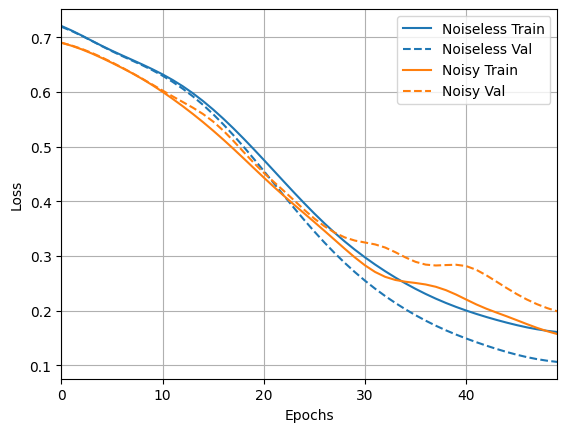

In [30]:
loss_plotter.plot(training_histories)

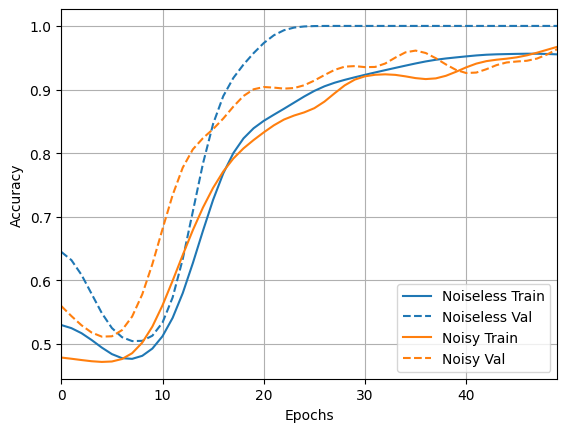

In [31]:
acc_plotter.plot(training_histories)

Success: The noisy model still managed to train under some mild depolarization noise. Try experimenting with different noise models to see how and when training might fail. Also look out for noisy functionality under `tfq.layers` and `tfq.noise`.